In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import statsmodels.api as sm
from scipy import stats
from scipy.stats import boxcox
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
# from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RepeatedKFold, cross_validate
# import kerastuner as kt
from tensorflow import keras
from tensorflow.keras import layers

2024-03-11 19:25:33.350814: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Read the dataset
df = pd.read_csv('Datasets/KaggleMovies.csv')
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.precision', 2)
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.400000,927000.000000,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.000000,46998772.000000,Warner Bros.,146.000000
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.800000,65000.000000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.000000,58853106.000000,Columbia Pictures,104.000000
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.700000,1200000.000000,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.000000,538375067.000000,Lucasfilm,124.000000
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.700000,221000.000000,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.000000,83453539.000000,Paramount Pictures,88.000000
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.300000,108000.000000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.000000,39846344.000000,Orion Pictures,98.000000


In [4]:
# Renaming columns
column_mapping = {
    'name' : 'Name',
    'rating' : 'Rating',
    'genre' : 'Genre',
    'year' : 'Year',
    'released' : 'Released',
    'score' : 'Score',
    'votes' : 'Votes',
    'director' : 'Director',
    'writer' : 'Writer',
    'star' : 'Star',
    'country' : 'Country',
    'budget' : 'Budget',
    'gross' : 'Gross Revenue',
    'company' : 'Company',
    'runtime' : 'Runtime'
}

df = df.rename(columns=column_mapping)

In [5]:
# Check for empty spaces
print(f"Shape: {df.shape}\n")
isna = df.isna().sum(axis=0)
isna

Shape: (7668, 15)



Name                0
Rating             77
Genre               0
Year                0
Released            2
Score               3
Votes               3
Director            0
Writer              3
Star                1
Country             3
Budget           2171
Gross Revenue     189
Company            17
Runtime             4
dtype: int64

In [6]:
# Remove rows with null values
df = df.dropna()
print(f"Shape: {df.shape}\n")
print(df.isna().sum(axis=0))

Shape: (5421, 15)

Name             0
Rating           0
Genre            0
Year             0
Released         0
Score            0
Votes            0
Director         0
Writer           0
Star             0
Country          0
Budget           0
Gross Revenue    0
Company          0
Runtime          0
dtype: int64


In [7]:
# Convert certain columns to appropiate data types
df.loc[:,['Votes', 'Budget', 'Runtime', 'Gross Revenue']] = df[['Votes', 'Budget', 'Runtime', 'Gross Revenue']].astype('int')
df.loc[:,'Score'] = df['Score'].apply(lambda x: float("{:.2f}".format(x)))
df.head()

/var/folders/pq/twq27s9n0mx81bdcyj4fvg900000gn/T/ipykernel_30183/2968057873.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,['Votes', 'Budget', 'Runtime', 'Gross Revenue']] = df[['Votes', 'Budget', 'Runtime', 'Gross Revenue']].astype('int')


,Name,Rating,Genre,Year,Released,Score,Votes,Director,Writer,Star,Country,Budget,Gross Revenue,Company,Runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.400000,927000,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000,46998772,Warner Bros.,146
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.800000,65000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000,58853106,Columbia Pictures,104
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.700000,1200000,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000,538375067,Lucasfilm,124
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.700000,221000,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000,83453539,Paramount Pictures,88
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.300000,108000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000,39846344,Orion Pictures,98


In [8]:
print(df.dtypes)

Name              object
Rating            object
Genre             object
Year               int64
Released          object
Score            float64
Votes              int64
Director          object
Writer            object
Star              object
Country           object
Budget             int64
Gross Revenue      int64
Company           object
Runtime            int64
dtype: object


In [9]:
# Check number of unique movie names
len(df['Name'].unique())

5336

In [10]:
#Drop duplicate movie names
df = df.drop_duplicates(subset=['Name'], keep='first')
print(f"Shape: {df.shape}\n")
df.head()

Shape: (5336, 15)



,Name,Rating,Genre,Year,Released,Score,Votes,Director,Writer,Star,Country,Budget,Gross Revenue,Company,Runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.400000,927000,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000,46998772,Warner Bros.,146
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.800000,65000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000,58853106,Columbia Pictures,104
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.700000,1200000,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000,538375067,Lucasfilm,124
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.700000,221000,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000,83453539,Paramount Pictures,88
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.300000,108000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000,39846344,Orion Pictures,98


In [49]:
def classify_score(score):
    if score <= 3:
        return 'very bad'
    elif score <= 5:
        return 'bad'
    elif score <= 8:
        return 'mid'
    else:
        return 'good'

# Create a new column 'group_rating' based on the score
df['group_rating'] = df['Score'].apply(classify_score)

# Selecting the required columns for features and target variable
X_movies = df[['Budget', 'Gross Revenue']]  # Features: budget and gross revenue
y_movies = df['group_rating']  # Target variable is now 'group_rating'

# Apply one-hot encoding to the target variable (rating)
encoder_movies = OneHotEncoder()
y_movies_encoded = encoder_movies.fit_transform(y_movies.values.reshape(-1, 1)).toarray()

# Apply min-max normalization to the 'budget' and 'gross' features
scaler_movies = MinMaxScaler()
X_movies_scaled = scaler_movies.fit_transform(X_movies)

rating_column_names = encoder_movies.get_feature_names_out(input_features=['y_movies'])
print(rating_column_names)
print(y_movies_encoded)

['y_movies_bad' 'y_movies_good' 'y_movies_mid' 'y_movies_very bad']
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


# Decision Tree Classifier


In [25]:
from sklearn.tree import DecisionTreeClassifier

### Base Model

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_movies_scaled, y_movies_encoded, test_size=0.2, random_state=42)

# Step 2: Create and train the decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

### Evaluate your model compare training vs test error

In [29]:
y_train_pred = clf.predict(X_train)

print("Training Set Evaluation:")
print(classification_report(y_train, y_train_pred, target_names=encoder_movies.categories_[0]))
print('Training Accuracy:', accuracy_score(y_train, y_train_pred))

y_test_pred = clf.predict(X_test)

print("\nTesting Set Evaluation:")
print(classification_report(y_test, y_test_pred, target_names=encoder_movies.categories_[0]))
print('Testing Accuracy:', accuracy_score(y_test, y_test_pred))

Training Set Evaluation:
              precision    recall  f1-score   support

         bad       1.00      1.00      1.00       321
        good       1.00      1.00      1.00       105
         mid       1.00      1.00      1.00      3816
    very bad       1.00      1.00      1.00        26

   micro avg       1.00      1.00      1.00      4268
   macro avg       1.00      1.00      1.00      4268
weighted avg       1.00      1.00      1.00      4268
 samples avg       1.00      1.00      1.00      4268

Training Accuracy: 1.0

Testing Set Evaluation:
              precision    recall  f1-score   support

         bad       0.08      0.08      0.08        72
        good       0.20      0.19      0.20        26
         mid       0.91      0.90      0.91       969
    very bad       0.00      0.00      0.00         1

   micro avg       0.83      0.83      0.83      1068
   macro avg       0.30      0.29      0.30      1068
weighted avg       0.84      0.83      0.83      1068
 sam

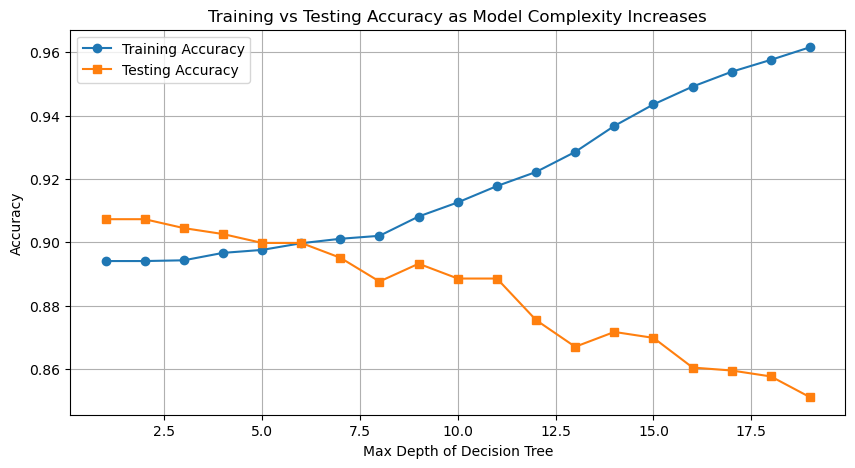

In [31]:
max_depth_range = range(1, 20)
train_accuracies = []
test_accuracies = []

for max_depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    
    train_pred = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    train_accuracies.append(train_accuracy)
    
    test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 5))
plt.plot(max_depth_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(max_depth_range, test_accuracies, label='Testing Accuracy', marker='s')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy as Model Complexity Increases')
plt.legend()
plt.grid(True)
plt.show()


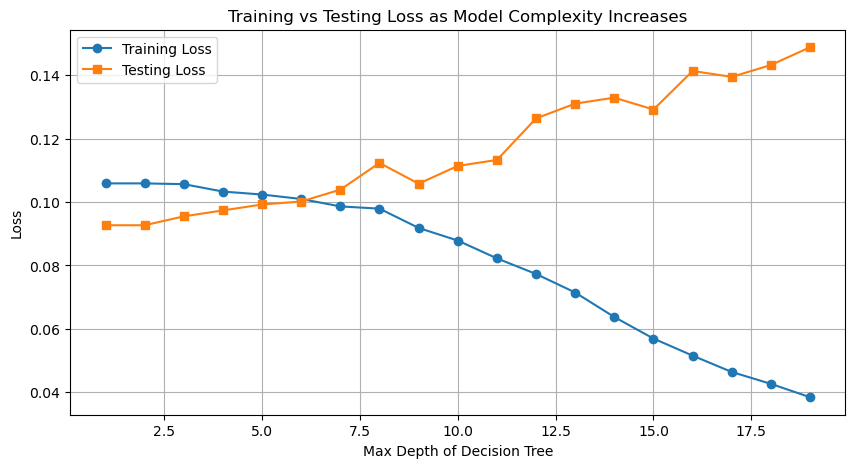

In [37]:
max_depth_range = range(1, 20)
train_losses = []
test_losses = []

for max_depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train, y_train)
    
    train_pred = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    train_loss = 1 - train_accuracy
    train_losses.append(train_loss)
    
    test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_loss = 1 - test_accuracy
    test_losses.append(test_loss)

plt.figure(figsize=(10, 5))
plt.plot(max_depth_range, train_losses, label='Training Loss', marker='o')
plt.plot(max_depth_range, test_losses, label='Testing Loss', marker='s')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('Loss')
plt.title('Training vs Testing Loss as Model Complexity Increases')
plt.legend()
plt.grid(True)
plt.show()


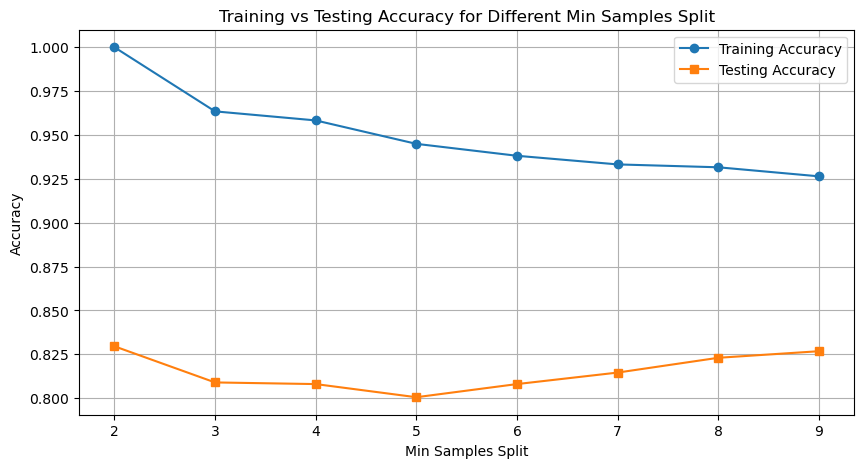

In [32]:
min_samples_split = range(2, 10)
train_accuracies = []
test_accuracies = []

for min_sample_split in min_samples_split:
    clf = DecisionTreeClassifier(min_samples_split=min_sample_split)
    clf.fit(X_train, y_train)
    
    train_pred = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    train_accuracies.append(train_accuracy)

    test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 5))
plt.plot(min_samples_split, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(min_samples_split, test_accuracies, label='Testing Accuracy', marker='s')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy for Different Min Samples Split')
plt.legend()
plt.grid(True)
plt.show()

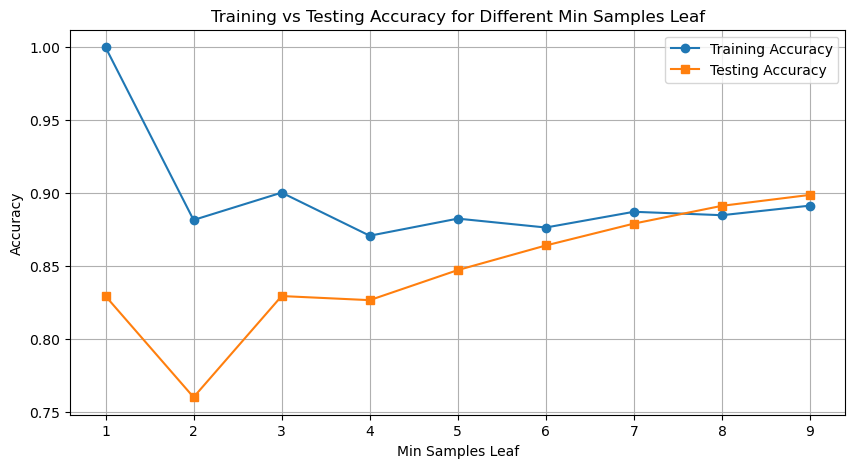

In [35]:
min_samples_leaf_range = range(1, 10)
train_accuracies = []
test_accuracies = []

for min_samples_leaf in min_samples_leaf_range:
    clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    clf.fit(X_train, y_train)
    
    train_pred = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, train_pred)
    train_accuracies.append(train_accuracy)
    
    test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 5))
plt.plot(min_samples_leaf_range, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(min_samples_leaf_range, test_accuracies, label='Testing Accuracy', marker='s')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy for Different Min Samples Leaf')
plt.legend()
plt.grid(True)
plt.show()

**Model Accuracy Graph**: Similar to the previous models, we want to see how the accuracy and training test react as we overfit by changing the hyperparameters of the decision tree. According to our graphs, our training accuracy increases as we increase the maximum depth of the decision tree while the testing accuracy decrease. These the training and testing data intersect when the maximum depth is around 6. As we increase the number of min splits, the training accuracy decreases while the testing accuracy initially decreases, but then increases. The highest accuracy is achieved when number of min split is 2. Lastly, as the number of min sample leaf increases, the training accuracy decreases while the testing accuracy increases. The testing and training data intersect at a value of 7.5 This might indicate that the decision tree performs well at a higher value of maximum depth and min sample leaf, and a lower value of min split.

**Model Loss Graph**: The error/loss for our graph is simply loss = 1 - accuracy. As we increase the max depth of the decision tree, the testing loss increases while our training set decreases which intersects at around a maximum depth of 6.

**Accuracy**: Our decision tree yielded an accuracy of 100% with our training set which indicates overfitting of the data. This is evident in the result of our testing set which yielded an accuracy of about 83%.

**Precision**: Our decision tree yielded an precision of 100% with our training set which indicates overfitting of the data. This is evident in the result of our testing set which yielded an weighted precision of about 84%.

**Recall**: Our decision tree yielded an recall of 100% with our training set which indicates overfitting of the data. This is evident in the result of our testing set which yielded an weighted recall of about 83%.

### Hyperparameter Tuning

In [36]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 20),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
best_clf = grid_search.best_estimator_

y_train_pred = best_clf.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print('Training Accuracy:', training_accuracy)

y_test_pred = best_clf.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_test_pred)
print('Testing Accuracy:', testing_accuracy)

Best parameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training Accuracy: 0.8940955951265229
Testing Accuracy: 0.9073033707865169


In [50]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_classes, y_pred_classes)
print(rating_column_names)
print(cm)

['y_movies_bad' 'y_movies_good' 'y_movies_mid' 'y_movies_very bad']
[[  6   2  64   0]
 [  0   5  21   0]
 [ 70  18 875   6]
 [  0   0   1   0]]


## Where does your model fit in the fitting graph, how does it compare to your first model?

After performing hypertuning with our decision tree model, our final decision tree model performs exceptionally well in the training data and performs well in the test data as well. Using the same features used in the previous model based on the "Gross Revenue" and "Budget", we are able to predict our target variable group ratings really well similar to our second model in which both the second model and the third model with an accuracy reaching up around 90%.

However as mentioned previously, fitting graphs with MSE values for the polynomial regression indicate that the model's performance varies with the degree of the polynomial. As the degree increases, the model fits the training data better but could potentially overfit. While our second model shows high classification accuracy, the fitting graphs from our first model indicate the regression model's capability to predict a continuous outcome based on its input. They serve different purposes and thus, their performances are not directly comparable.

In conclusion, for the specific task of classifying movies into 'group ratings', our second and third model seems to have similar performance in performing classification according to the accuracy metrics. And as mentioned in the second model, the task of predicting 'Gross Revenue' from 'Budget', the regression analysis of our first model indicates a variable fit depending on the polynomial degree, and its performance should be assessed by how well it generalizes to new, unseen data.

## Did you perform hyper parameter tuning? K-fold Cross validation? Feature expansion? What were the results?

**1. Hyperparameter Tuning**
- Hyperparameter tuning was conducted using GridSearchCV, focusing on the criterion, max depth, min samples split, and min samples leaf
- The tuning was conducted with 5 cross validations and scored using accuracy
- Based on our tuning, using Gini with a max depth of 1, min sample leaf of 1, and min sample split of 2 yielded the best accuracy
- CV=5 mitigates the risk of overfitting and ensures the performance metrics not to be overly optimistic
- Our testing accuracy increased from about 83% to 90%, indicating a 7% improvement from our base model

## What is the conclusion of your 3rd model?

The third model demonstrates strong performance across various evaluation metrics, including accuracy, precision, and recall, on both the training and testing datasets. These metrics suggest that the model effectively identifies the majority of instances across its predicted classes, indicating its proficiency in capturing underlying patterns within the data. Moreover, the model exhibits consistent high performance on the testing data, implying that it has successfully generalized beyond the constraints of the training dataset.

However, a detailed examination of the confusion matrix reveals certain tendencies of the model to misclassify "mid" movies as "bad" and vice versa. Despite these occasional misclassifications, the model's overall performance remains robust. These insights underscore the importance of considering nuanced aspects of model performance beyond aggregate metrics, allowing for a more comprehensive evaluation of its predictive capabilities.

In conclusion, the third model emerges as a reliable classifier for predicting 'group ratings' based on the 'Gross Revenue' and 'Budget' features. Its high degree of accuracy, precision, and recall are strong indicators of its reliability and effectiveness, making it a good model.

## What can be done to possibly to improve it?

To refine our approach and enhance the model's predictive accuracy and reliability, we propose several strategies:

- **Increase Cross-Validation Folds:** Increasing the number of folds in cross-validation can lead to a more reliable estimate of model performance. By using more folds, each instance in the dataset gets to be in the test set exactly once and in the training set K−1 times (where K is the number of folds), providing a more comprehensive evaluation of the model's performance across different subsets of the data. </br></br>

- **Expand the Parameter Grid:** Extending the range or adding new parameters to the param_grid can potentially lead to finding a better model. </br></br>

- **Implement Randomized Search:** Instead of using GridSearchCV, we can use RandomizedSearchCV which samples a given number of candidates from the parameter space with a specified distribution. This approach can be more efficient than Grid Search and provide a good approximation of the best parameters with significantly less computational time. </br></br>

- **Feature Engineering and Selection:** We could create new features from existing ones through domain knowledge and select the most relevant features in the data. By doing so, we can implement feature importance scores for feature selection which can lead to a more effective and efficient model. </br></br>

## Model 3: Decision Tree Classifier
### Data Preprocessing
Our decision tree preprocessing involved creating a new target variable 'group_rating' derived from the 'Score' feature, which classifies movies into 'very bad,' 'bad,' 'mid,' and 'good' categories, and applied one-hot encoding to the target variable. We selected 'Budget' and 'Gross Revenue' as feature inputs and performed MinMax scaling on the feature inputs to normalize the data.

### Training and Testing Performance
The decision tree was trained and tested, revealing the following results:

- Confusion Matrix indicated a tendency of the model to misclassify "mid" movies as "bad" and vice versa.
- Accuracy was high at about 90%, which should be interpreted cautiously due to the apparent class imbalance.
- Precision was recorded at about 84%, suggesting the model was mostly correct when it made predictions, albeit likely skewed by class imbalance.
- Recall was recorded at about 83%, again reflecting the bias towards the "mid" and "bad" movies.

### Hyperparameter Tuning
Hyperparameter tuning identified that using Gini with a max depth of 1, min sample leaf of 1, and min sample split of 2 yielded the best accuracy, increasing our testing accuracy from about 83% to 90%

### Analysis
The model demonstrated high classification accuracy for the 'group ratings' based on 'Gross Revenue' and 'Budget'. However, the analysis indicates a potential class imbalance, as shown by the model tend to misclassify "mid" movies as "bad" and vice versa, which is a further issue to address to improve the predictive performance of the model.

. Evaluate your data, labels and loss function. Were they sufficient or did you have have to change them.

2. Train your second model

3. Evaluate your model compare training vs test error

4. Where does your model fit in the fitting graph, how does it compare to your first model?

5. Did you perform hyper parameter tuning? K-fold Cross validation? Feature expansion? What were the results?

5. What is the plan for the next model you are thinking of and why?

6. Update your readme with this info added to the readme with links to the jupyter notebook!

7. Conclusion section: What is the conclusion of your 2nd model? What can be done to possibly improve it? How did it perform to your first and why?

Please make sure your second model has been trained, and predictions for train, val and test are done and analyzed. 